# pLUTo Simulator

## An interactive tutorial

This Jupyter notebook demonstrates the functionality of the pLUTo timing simulator we have implemented, and is able to reproduce the figures that are shown in the manuscript that is slated to appear in MICRO 2022.

# Set Up + Initial Run

In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean

from memory_models import DDR4, HMC
from pluto_core import pluto_configs, Workloads
from pluto_sim import pLUTo

In [2]:
# Choose which memory configuration to simulate
# Currently, only DDR4 and HMC are supported

mem_configs = [DDR4(), HMC()]

In [3]:
# Create directory to store results

output_directory = "pysim"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [4]:
# Iterate over pLUTo configurations
for pluto_config in pluto_configs:
    print("".join(["\nEvaluating pLUTo-", pluto_config]))

    filename = "".join(["pysim_", pluto_config, ".csv"])
    with open(os.path.join(output_directory, filename), "w") as f:
        f.write("workload,memory,parallelism,tXAW,energy (nJ),execution time (ns)\n")

        for m in mem_configs:
            print("Evaluating memory ", m.name, "...")
            print("Running workload ", end="")
            for w in Workloads:
                print(f"{w.name} ", end="")
                parallelism = m.parallelism
                for p in parallelism:
                    for tXAW in np.linspace(0, 13.328, num=3):
                        pluto = pLUTo(pluto_config, w, m, p, tXAW)
                        f.write(
                            f"{w.name},{m.name},{p},{tXAW},{pluto.get_energy():.4f},{pluto.get_execution_time()[0]:.4f}\n"
                        )
            print("")



Evaluating pLUTo-GSA
Evaluating memory  DDR4 ...
Running workload VecAdd4_KSA VecAdd8 VecMulQ8 VecMulQ16 CRC8 CRC16 CRC32 Salsa20 VMPC BitWiseOps BitCount BitCount_short ImgBin ColorGrade LeNet4 LeNet1 
Evaluating memory  3DS ...
Running workload VecAdd4_KSA VecAdd8 VecMulQ8 VecMulQ16 CRC8 CRC16 CRC32 Salsa20 VMPC BitWiseOps BitCount BitCount_short ImgBin ColorGrade LeNet4 LeNet1 

Evaluating pLUTo-BSA
Evaluating memory  DDR4 ...
Running workload VecAdd4_KSA VecAdd8 VecMulQ8 VecMulQ16 CRC8 CRC16 CRC32 Salsa20 VMPC BitWiseOps BitCount BitCount_short ImgBin ColorGrade LeNet4 LeNet1 
Evaluating memory  3DS ...
Running workload VecAdd4_KSA VecAdd8 VecMulQ8 VecMulQ16 CRC8 CRC16 CRC32 Salsa20 VMPC BitWiseOps BitCount BitCount_short ImgBin ColorGrade LeNet4 LeNet1 

Evaluating pLUTo-GMC
Evaluating memory  DDR4 ...
Running workload VecAdd4_KSA VecAdd8 VecMulQ8 VecMulQ16 CRC8 CRC16 CRC32 Salsa20 VMPC BitWiseOps BitCount BitCount_short ImgBin ColorGrade LeNet4 LeNet1 
Evaluating memory  3DS ...

In [5]:
# Retrieve results from CSV files

pluto_gsa = pd.read_csv(os.path.join(output_directory, "pysim_gsa.csv"))
pluto_bsa = pd.read_csv(os.path.join(output_directory, "pysim_bsa.csv"))
pluto_gmc = pd.read_csv(os.path.join(output_directory, "pysim_gmc.csv"))

In [6]:
# Retrieve baseline results from saved files
baselines_directory = "baselines"
cpu = pd.read_csv(os.path.join(baselines_directory, "cpu.csv"))
gpu1 = pd.read_csv(os.path.join(baselines_directory, "gpu1.csv"))
gpu2 = pd.read_csv(os.path.join(baselines_directory, "gpu2.csv"))
fpga = pd.read_csv(os.path.join(baselines_directory, "fpga.csv"))
ndp = pd.read_csv(os.path.join(baselines_directory, "ndp.csv"))

# Figure 7

> Speedup of GPU, NDP, and pLUTo relative to the baseline CPU. The y-axis uses a logarithmic scale; higher is better.

In [7]:
labels = cpu.columns.values[1:]
cpu_values = cpu[cpu['Metric'] == 'Total Time (s)'][labels]

gpu1_values = gpu1[gpu1['Metric'] == 'Total Time (s)'][labels]
gpu2_values = gpu2[gpu2['Metric'] == 'Total Time (s)'][labels]
ndp_values = ndp[ndp['Metric'] == 'Total Time (s)'][labels]

In [8]:
pluto_labels = ["CRC8", "CRC16", "CRC32", "Salsa20", "VMPC", "ImgBin", "ColorGrade"]

def create_filter(df, workload_list, memory, parallelism, tXAW):
    return np.logical_and.reduce(
        (
            df["memory"] == memory,
            df["parallelism"] == parallelism,
            df["tXAW"] == tXAW,
            df["workload"].isin(workload_list),
        )
    )

In [9]:
pluto_gsa_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_bsa_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_gmc_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_gsa_3ds_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].values
pluto_bsa_3ds_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].values
pluto_gmc_3ds_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'3DS',512,0)]['execution time (ns)'].values

pluto_gsa_values = pd.DataFrame([np.append(pluto_gsa_values,gmean(pluto_gsa_values))], columns=cpu.columns[1:])
pluto_bsa_values = pd.DataFrame([np.append(pluto_bsa_values,gmean(pluto_bsa_values))], columns=cpu.columns[1:])
pluto_gmc_values = pd.DataFrame([np.append(pluto_gmc_values,gmean(pluto_gmc_values))], columns=cpu.columns[1:])
pluto_gsa_3ds_values = pd.DataFrame([np.append(pluto_gsa_3ds_values,gmean(pluto_gsa_3ds_values))], columns=cpu.columns[1:])
pluto_bsa_3ds_values = pd.DataFrame([np.append(pluto_bsa_3ds_values,gmean(pluto_bsa_3ds_values))], columns=cpu.columns[1:])
pluto_gmc_3ds_values = pd.DataFrame([np.append(pluto_gmc_3ds_values,gmean(pluto_gmc_3ds_values))], columns=cpu.columns[1:])

In [10]:
cpu_values_normalized = cpu_values.divide(cpu_values)
assert np.all(cpu_values_normalized.values == 1)

gpu1_values_normalized = cpu_values.divide(gpu1_values)
gpu2_values_normalized = cpu_values.divide(gpu2_values)
ndp_values_normalized = cpu_values.divide(ndp_values)

In [11]:
pluto_gsa_values_normalized = cpu_values.divide(pluto_gsa_values.divide(1e9))
pluto_gsa_values_normalized

pluto_bsa_values_normalized = cpu_values.divide(pluto_bsa_values.divide(1e9))
pluto_bsa_values_normalized

pluto_gmc_values_normalized = cpu_values.divide(pluto_gmc_values.divide(1e9))
pluto_gmc_values_normalized

pluto_gsa_3ds_values_normalized = cpu_values.divide(pluto_gsa_3ds_values.divide(1e9))
pluto_gsa_values_normalized

pluto_bsa_3ds_values_normalized = cpu_values.divide(pluto_bsa_3ds_values.divide(1e9))
pluto_bsa_values_normalized

pluto_gmc_3ds_values_normalized = cpu_values.divide(pluto_gmc_3ds_values.divide(1e9))
pluto_gmc_values_normalized

,CRC-8,CRC-16,CRC-32,Salsa20,VMPC,ImgBin,ColorGrade,Geomean
0,2235.366131,2345.390154,2294.403411,955.782657,90.564706,4451.625668,2431.906615,1413.147595


In [12]:
df_plot_fig7 = pd.concat(
    [
        gpu1_values_normalized,
        gpu2_values_normalized,
        ndp_values_normalized,
        pluto_gsa_values_normalized,
        pluto_bsa_values_normalized,
        pluto_gmc_values_normalized,
        pluto_gsa_3ds_values_normalized,
        pluto_bsa_3ds_values_normalized,
        pluto_gmc_3ds_values_normalized,
    ]
)

labels = ["GPU1", "GPU2", "NDP", "GSA", "BSA", "GMC", "GSA-3DS", "BSA-3DS", "GMC-3DS"]
df_plot_fig7.index = labels

df_plot_fig7 = df_plot_fig7.transpose()
df_plot_fig7

,GPU1,GPU2,NDP,GSA,BSA,GMC,GSA-3DS,BSA-3DS,GMC-3DS
CRC-8,2795.302013,5141.975309,1400.000000,561.024509,1122.049017,2235.366131,778.834023,1557.668042,3103.214139
CRC-16,2923.076923,5395.061728,1468.907563,588.637960,1177.275919,2345.390154,817.167991,1634.335977,3255.953370
CRC-32,2850.000000,5245.398773,1103.225806,575.841483,1151.682965,2294.403411,799.403469,1598.806934,3185.171775
Salsa20,60.236220,36.867470,111.678832,252.920435,496.790986,955.782657,351.113074,689.662779,1326.851210
VMPC,35.064935,14.876033,375.000000,22.730342,45.460200,90.564706,31.555064,63.109454,125.725121
ImgBin,512.658228,905.027933,0.048358,1117.253708,2234.507415,4451.625668,1551.011029,3102.022059,6179.903868
ColorGrade,191.144708,415.492958,0.028641,610.351562,1220.703125,2431.906615,847.311581,1694.623162,3376.058595
Geomean,234.567901,302.961276,43.322476,357.361022,712.880090,1413.147595,496.101183,989.645300,1961.781360


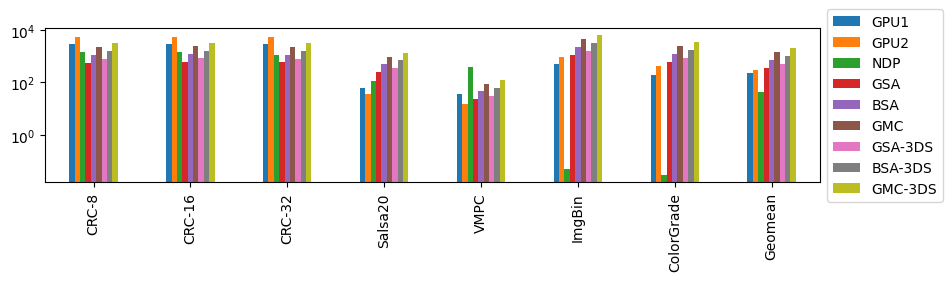

In [13]:
df_plot_fig7.plot(kind="bar", logy=True, figsize=(10,2)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

# Figure 8

> Normalized speedup of GPU, NDP, and pLUTo relative to CPU. The y-axis uses a logarithmic scale; higher is better.

In [14]:
areas = pd.read_csv(os.path.join(baselines_directory, "areas.csv"))

df_plot_fig8 = df_plot_fig7

In [15]:
areas = pd.read_csv(os.path.join(baselines_directory, "areas.csv"))

df_plot_fig8 = df_plot_fig7.copy()

df_plot_fig8['GPU1'] = df_plot_fig7['GPU1'].divide(float(areas['gpu1']))
df_plot_fig8['GPU2'] = df_plot_fig7['GPU2'].divide(float(areas['gpu2']))
# df_plot_fig8['NDP'] = df_plot_fig7['NDP'].divide(float(areas['ndp']))
df_plot_fig8['GSA'] = df_plot_fig7['GSA'].divide(float(areas['pLUTo-GSA-16']))
df_plot_fig8['BSA'] = df_plot_fig7['BSA'].divide(float(areas['pLUTo-BSA-16']))
df_plot_fig8['GMC'] = df_plot_fig7['GMC'].divide(float(areas['pLUTo-GMC-16']))
df_plot_fig8['GSA-3DS'] = df_plot_fig7['GSA-3DS'].divide(float(areas['pLUTo-GSA-3DS-256']))
df_plot_fig8['BSA-3DS'] = df_plot_fig7['BSA-3DS'].divide(float(areas['pLUTo-BSA-3DS-256']))
df_plot_fig8['GMC-3DS'] = df_plot_fig7['GMC-3DS'].divide(float(areas['pLUTo-GMC-3DS-256']))

df_plot_fig8

,GPU1,GPU2,NDP,GSA,BSA,GMC,GSA-3DS,BSA-3DS,GMC-3DS
CRC-8,3.707297,8.187859,1400.000000,667.886320,1260.729233,2378.049075,19470.850578,38941.701058,62064.282779
CRC-16,3.876760,8.590863,1468.907563,700.759476,1322.781932,2495.095908,20429.199766,40858.399430,65119.067405
CRC-32,3.779841,8.352546,1103.225806,685.525575,1294.025803,2440.854693,19985.086728,39970.173355,63703.435505
Salsa20,0.079889,0.058706,111.678832,301.095756,558.192120,1016.790061,8777.826860,17241.569479,26537.024209
VMPC,0.046505,0.023688,375.000000,27.059931,51.078876,96.345432,788.876588,1577.736342,2514.502428
ImgBin,0.679918,1.441127,0.048358,1330.063938,2510.682489,4735.771987,38775.275735,77550.551471,123598.077363
ColorGrade,0.253508,0.661613,0.028641,726.609003,1371.576545,2587.134697,21182.789522,42365.579044,67521.171893
Geomean,0.311098,0.482422,43.322476,425.429788,800.988865,1503.348505,12402.529585,24741.132495,39235.627202


/var/folders/x5/11g4qnk17rg91wczbpncf_700000gn/T/ipykernel_70969/672516697.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-'] + df_plot_fig8.index.to_list())


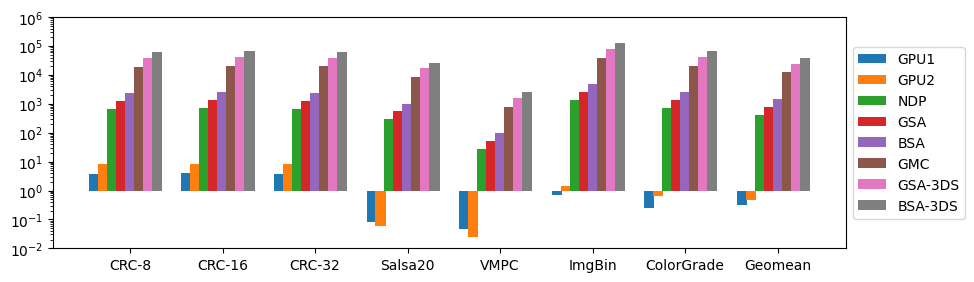

In [16]:
base_value = 1
ymin = min(df_plot_fig8.min())
ymin = 10**math.floor(math.log(ymin, 10))

ymax = max(df_plot_fig8.max())
ymax = 10**math.ceil(math.log(ymax, 10))

x = np.arange(len(df_plot_fig8.columns[1:]))  # the label locations
width = 1/9  # the width of the bars
offset = np.linspace(width * (-3.5), width * 3.5, len(df_plot_fig8.columns))

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylim([ymin, ymax])
ax.set_yticks(10 ** np.arange(math.floor(math.log(ymin, 10)), math.ceil(math.log(ymax, 10)) + 1, dtype=float))
rects1 = ax.bar(x + offset[0], df_plot_fig8['GPU1'] - base_value, width, bottom=base_value, label='GPU1')
rects2 = ax.bar(x + offset[1], df_plot_fig8['GPU2'] - base_value, width, bottom=base_value, label='GPU2')
rects3 = ax.bar(x + offset[2], df_plot_fig8['GSA'] - base_value, width, bottom=base_value, label='GSA')
rects4 = ax.bar(x + offset[3], df_plot_fig8['BSA'] - base_value, width, bottom=base_value, label='BSA')
rects5 = ax.bar(x + offset[4], df_plot_fig8['GMC'] - base_value, width, bottom=base_value, label='GMC')
rects6 = ax.bar(x + offset[5], df_plot_fig8['GSA-3DS'] - base_value, width, bottom=base_value, label='GSA-3DS')
rects7 = ax.bar(x + offset[6], df_plot_fig8['BSA-3DS'] - base_value, width, bottom=base_value, label='BSA-3DS')
rects8 = ax.bar(x + offset[7], df_plot_fig8['GMC-3DS'] - base_value, width, bottom=base_value, label='GMC-3DS')

ax.set_xticklabels(['-'] + df_plot_fig8.index.to_list())
ax.legend(labels, loc='center left',bbox_to_anchor=(1.0, 0.5))

fig.tight_layout()

plt.yscale('log')
plt.show()

# Figure 9

> pLUTo speedup relative to FPGA baseline.

In [17]:
labels = fpga.columns[1:]
fpga

,Metric,Add4,Add8,Mul8,Mul16,CRC8,CRC16,CRC32,BitCount,BitCount_short,ImgBin,GeoMean
0,Total Time (s),0.00459,0.00229,0.00229,0.00115,1.35,0.679,0.343,0.00164,0.00328,0.0117,0.0149


In [18]:
pluto_labels = [
    "VecAdd4_KSA",
    "VecAdd8",
    "VecMulQ8",
    "VecMulQ16",
    "CRC8",
    "CRC16",
    "CRC32",
    "BitCount",
    "BitCount_short",
    "ImgBin"
]

pluto_labels_with_geomean = pluto_labels + ["Geomean"]

In [19]:
pluto_gsa_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_bsa_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_gmc_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_gsa_3ds_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].values
pluto_bsa_3ds_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].values
pluto_gmc_3ds_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'3DS',512,0)]['execution time (ns)'].values

pluto_gsa_values = pd.DataFrame([np.append(pluto_gsa_values,gmean(pluto_gsa_values))], columns=labels)
pluto_bsa_values = pd.DataFrame([np.append(pluto_bsa_values,gmean(pluto_bsa_values))], columns=labels)
pluto_gmc_values = pd.DataFrame([np.append(pluto_gmc_values,gmean(pluto_gmc_values))], columns=labels)
pluto_gsa_3ds_values = pd.DataFrame([np.append(pluto_gsa_3ds_values,gmean(pluto_gsa_3ds_values))], columns=labels)
pluto_bsa_3ds_values = pd.DataFrame([np.append(pluto_bsa_3ds_values,gmean(pluto_bsa_3ds_values))], columns=labels)
pluto_gmc_3ds_values = pd.DataFrame([np.append(pluto_gmc_3ds_values,gmean(pluto_gmc_3ds_values))], columns=labels)

In [20]:
pluto_gsa_values_normalized = fpga[labels].divide(pluto_gsa_values.divide(1e9))
pluto_gsa_values_normalized

pluto_bsa_values_normalized = fpga[labels].divide(pluto_bsa_values.divide(1e9))
pluto_bsa_values_normalized

pluto_gmc_values_normalized = fpga[labels].divide(pluto_gmc_values.divide(1e9))
pluto_gmc_values_normalized

pluto_gsa_3ds_values_normalized = fpga[labels].divide(pluto_gsa_3ds_values.divide(1e9))
pluto_gsa_values_normalized

pluto_bsa_3ds_values_normalized = fpga[labels].divide(pluto_bsa_3ds_values.divide(1e9))
pluto_bsa_values_normalized

pluto_gmc_3ds_values_normalized = fpga[labels].divide(pluto_gmc_3ds_values.divide(1e9))
pluto_gmc_values_normalized

,Add4,Add8,Mul8,Mul16,CRC8,CRC16,CRC32,BitCount,BitCount_short,ImgBin,GeoMean
0,2366.076952,903.481362,102.74661,15.862244,362.274223,182.210517,92.044488,450.658401,13625.789299,3215.062982,458.602845


In [21]:
df_plot_fig9 = pd.concat(
    [
        pluto_gsa_values_normalized,
        pluto_bsa_values_normalized,
        pluto_gmc_values_normalized,
        pluto_gsa_3ds_values_normalized,
        pluto_bsa_3ds_values_normalized,
        pluto_gmc_3ds_values_normalized,
    ]
)

labels = ["GSA", "BSA", "GMC", "GSA-3DS", "BSA-3DS", "GMC-3DS"]
df_plot_fig9.index = labels

df_plot_fig9 = df_plot_fig9.transpose()

# Set workload order equal to the paper
df_plot_fig9 = df_plot_fig9.iloc[np.array([0,1,2,3,8,7,4,5,6,9,10])]

df_plot_fig9

,GSA,BSA,GMC,GSA-3DS,BSA-3DS,GMC-3DS
Add4,2366.076952,2366.076952,2366.076952,3284.671533,3284.671533,3284.671533
Add8,903.481362,903.481362,903.481362,1254.244715,1254.244715,1254.244715
Mul8,34.839113,62.345090,102.746610,48.364887,86.549655,142.636470
Mul16,4.669658,8.827684,15.862244,6.482584,12.254902,22.020527
BitCount_short,3619.350282,7238.700565,13625.789299,5024.509804,10049.019608,18915.801615
BitCount,113.104696,226.209393,450.658401,157.015931,314.031863,625.619898
CRC8,90.922339,181.844679,362.274223,126.221600,252.443200,502.921859
CRC16,45.730569,91.461138,182.210517,63.484790,126.969580,252.951068
CRC32,23.101009,46.202018,92.044488,32.069636,64.139272,127.779406
ImgBin,806.905456,1613.810911,3215.062982,1120.174632,2240.349265,4463.263905


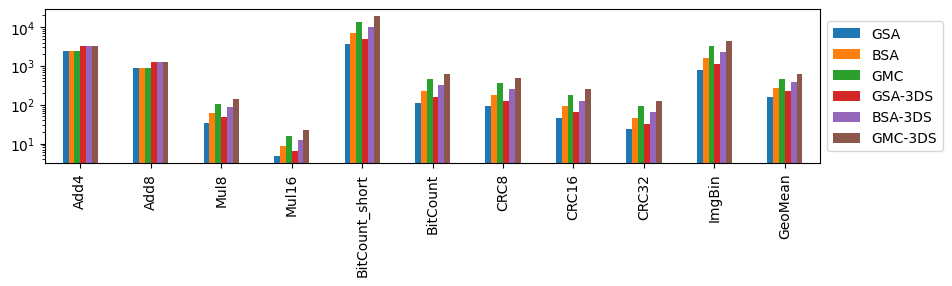

In [22]:
df_plot_fig9.plot(kind="bar", logy=True, figsize=(10,2)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

# Figure 10

> Energy efficiency of GPU, NDP, and pLUTo compared to the baseline CPU. The y-axis uses a logarithmic scale; higher is better.

In [23]:
labels = cpu.columns.values[1:]
cpu_values = cpu[cpu['Metric'] == 'Energy (J)'][labels].multiply(1e12)

gpu1_values = gpu1[gpu1['Metric'] == 'Energy (J)'][labels].multiply(1e12)
gpu2_values = gpu2[gpu2['Metric'] == 'Energy (J)'][labels].multiply(1e12)

In [24]:
pluto_labels = ["CRC8", "CRC16", "CRC32", "Salsa20", "VMPC", "ImgBin", "ColorGrade"]

def create_filter(df, workload_list, memory, parallelism, tXAW):
    return np.logical_and.reduce(
        (
            df["memory"] == memory,
            df["parallelism"] == parallelism,
            df["tXAW"] == tXAW,
            df["workload"].isin(workload_list),
        )
    )

In [25]:
pluto_gsa_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',16,0)]['energy (nJ)'].values
pluto_bsa_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',16,0)]['energy (nJ)'].values
pluto_gmc_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',16,0)]['energy (nJ)'].values
pluto_gsa_3ds_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'3DS',512,0)]['energy (nJ)'].values
pluto_bsa_3ds_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'3DS',512,0)]['energy (nJ)'].values
pluto_gmc_3ds_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'3DS',512,0)]['energy (nJ)'].values

pluto_gsa_values = pd.DataFrame([np.append(pluto_gsa_values,gmean(pluto_gsa_values))], columns=cpu.columns[1:])
pluto_bsa_values = pd.DataFrame([np.append(pluto_bsa_values,gmean(pluto_bsa_values))], columns=cpu.columns[1:])
pluto_gmc_values = pd.DataFrame([np.append(pluto_gmc_values,gmean(pluto_gmc_values))], columns=cpu.columns[1:])
pluto_gsa_3ds_values = pd.DataFrame([np.append(pluto_gsa_3ds_values,gmean(pluto_gsa_3ds_values))], columns=cpu.columns[1:])
pluto_bsa_3ds_values = pd.DataFrame([np.append(pluto_bsa_3ds_values,gmean(pluto_bsa_3ds_values))], columns=cpu.columns[1:])
pluto_gmc_3ds_values = pd.DataFrame([np.append(pluto_gmc_3ds_values,gmean(pluto_gmc_3ds_values))], columns=cpu.columns[1:])

In [26]:
df_plot_fig10 = pd.concat(
    [
        cpu_values,
        gpu1_values,
        gpu2_values,
        pluto_gsa_values,
        pluto_bsa_values,
        pluto_gmc_values,
        pluto_gsa_3ds_values,
        pluto_bsa_3ds_values,
        pluto_gmc_3ds_values,
    ]
)

labels = ["CPU", "GPU1", "GPU2", "GSA", "BSA", "GMC", "GSA-3DS", "BSA-3DS", "GMC-3DS"]
df_plot_fig10.index = labels

df_plot_fig10 = df_plot_fig10.transpose()
df_plot_fig10

,CPU,GPU1,GPU2,GSA,BSA,GMC,GSA-3DS,BSA-3DS,GMC-3DS
CRC-8,6.950000e+07,1.650000e+05,1.760000e+05,1.332228e+08,1.304377e+08,1.285285e+08,4.466766e+08,3.575560e+08,2.964586e+08
CRC-16,7.290000e+07,1.650000e+05,1.770000e+05,1.332228e+08,1.304377e+08,1.285285e+08,4.466766e+08,3.575560e+08,2.964586e+08
CRC-32,7.140000e+07,1.660000e+05,1.770000e+05,1.332228e+08,1.304377e+08,1.285285e+08,4.466766e+08,3.575560e+08,2.964586e+08
Salsa20,1.280000e+08,1.400000e+07,4.520000e+07,5.332633e+08,5.221232e+08,5.144861e+08,1.798618e+09,1.442136e+09,1.197746e+09
VMPC,4.500000e+07,8.500000e+06,3.960000e+07,8.912150e+07,4.456122e+07,1.401253e+07,2.851888e+09,1.425959e+09,4.484010e+08
ImgBin,1.410000e+11,1.830000e+09,1.960000e+09,5.439488e+03,2.719744e+03,8.552000e+02,1.740636e+05,8.703181e+04,2.736640e+04
ColorGrade,7.750000e+10,2.690000e+09,2.320000e+09,5.439488e+03,2.719744e+03,8.552000e+02,1.740636e+05,8.703181e+04,2.736640e+04
Geomean,5.830000e+08,8.270000e+06,1.200000e+07,8.544413e+06,6.272317e+06,3.788191e+06,7.539672e+07,4.934175e+07,2.700722e+07


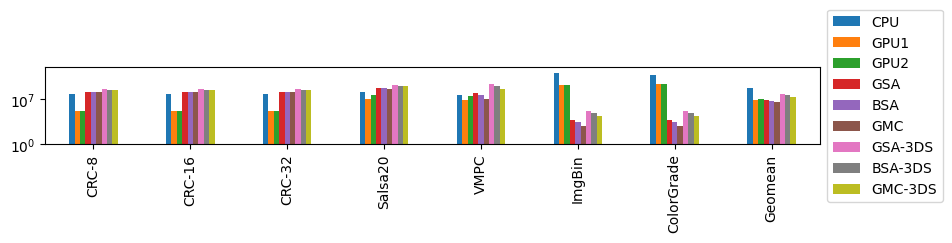

In [27]:
df_plot_fig10.plot(kind="bar", logy=True, figsize=(10,1), ylim=(1,1e12)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

# Figure 11

> Fraction of time spent setting up LUTs as a function of the volume of data to be queried.

Please refer to the spreadsheet available under `figure_11/LUT Loading Times.xlsx`

# Figure 12

> The impact of different values of tFAW on pLUTo’s performance.

In [28]:
pluto_labels = [
    "CRC8",
    "CRC16",
    "CRC32",
    "Salsa20",
    "VMPC",
    "ImgBin",
    "ColorGrade",
]

txaw_0 = pluto_bsa[create_filter(pluto_bsa, pluto_labels, "DDR4", 16, 0)][["workload", "tXAW", "execution time (ns)"]]
txaw_1 = pluto_bsa[create_filter(pluto_bsa, pluto_labels, "DDR4", 16, 6.664)][["workload", "tXAW", "execution time (ns)"]]
txaw_2 = pluto_bsa[create_filter(pluto_bsa, pluto_labels, "DDR4", 16, 13.328)][["workload", "tXAW", "execution time (ns)"]]

df_plot_fig12 = pd.DataFrame({
    '0%': txaw_0['execution time (ns)'].values,
    '50%': txaw_1['execution time (ns)'].values,
    '100%': txaw_2['execution time (ns)'].values,
}, index=txaw_0['workload'].values)

df_plot_fig12['100%'] = df_plot_fig12['0%'].divide(df_plot_fig12['100%']).multiply(100)
df_plot_fig12['50%'] = df_plot_fig12['0%'].divide(df_plot_fig12['50%']).multiply(100)
df_plot_fig12['0%'] = df_plot_fig12['0%'].divide(df_plot_fig12['0%']).multiply(100)

df_plot_fig12

,0%,50%,100%
CRC8,100.0,89.473019,80.951292
CRC16,100.0,89.473019,80.951292
CRC32,100.0,89.473019,80.951292
Salsa20,100.0,89.473019,80.951292
VMPC,100.0,89.473049,80.951342
ImgBin,100.0,89.473019,80.951292
ColorGrade,100.0,89.473019,80.951292


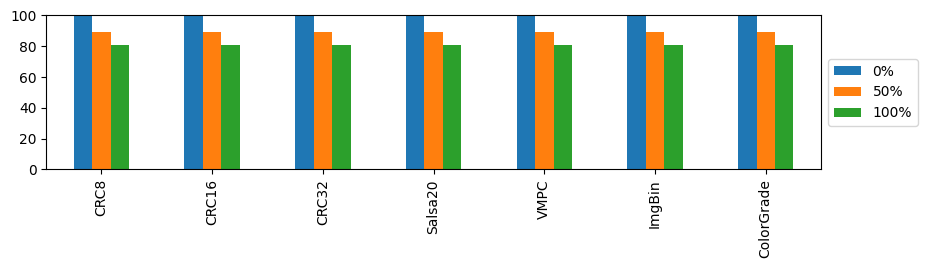

In [29]:
fig12 = df_plot_fig12.plot(kind="bar", figsize=(10,2))
fig12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
fig12.set_ylim((0, 100))
plt.show()

# Figure 13

> Geometric mean speedup of pLUTo over CPU, for varying degrees of subarray-level parallelism.

In [30]:
labels = cpu.columns.values[1:]
cpu_values = cpu[cpu['Metric'] == 'Total Time (s)'][labels]

In [31]:
pluto_labels = ["CRC8", "CRC16", "CRC32", "Salsa20", "VMPC", "ImgBin", "ColorGrade"]

def create_filter(df, workload_list, memory, parallelism, tXAW):
    return np.logical_and.reduce(
        (
            df["memory"] == memory,
            df["parallelism"] == parallelism,
            df["tXAW"] == tXAW,
            df["workload"].isin(workload_list),
        )
    )

In [32]:
pluto_gsa_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_bsa_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_gmc_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',16,0)]['execution time (ns)'].values
pluto_gsa_3ds_values = pluto_gsa[create_filter(pluto_gsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].values
pluto_bsa_3ds_values = pluto_bsa[create_filter(pluto_bsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].values
pluto_gmc_3ds_values = pluto_gmc[create_filter(pluto_gmc,pluto_labels,'3DS',512,0)]['execution time (ns)'].values

pluto_gsa_values = pd.DataFrame([np.append(pluto_gsa_values,gmean(pluto_gsa_values))], columns=cpu.columns[1:])
pluto_bsa_values = pd.DataFrame([np.append(pluto_bsa_values,gmean(pluto_bsa_values))], columns=cpu.columns[1:])
pluto_gmc_values = pd.DataFrame([np.append(pluto_gmc_values,gmean(pluto_gmc_values))], columns=cpu.columns[1:])
pluto_gsa_3ds_values = pd.DataFrame([np.append(pluto_gsa_3ds_values,gmean(pluto_gsa_3ds_values))], columns=cpu.columns[1:])
pluto_bsa_3ds_values = pd.DataFrame([np.append(pluto_bsa_3ds_values,gmean(pluto_bsa_3ds_values))], columns=cpu.columns[1:])
pluto_gmc_3ds_values = pd.DataFrame([np.append(pluto_gmc_3ds_values,gmean(pluto_gmc_3ds_values))], columns=cpu.columns[1:])

In [33]:
cpu_values_normalized = cpu_values.divide(cpu_values)
assert np.all(cpu_values_normalized.values == 1)

In [34]:
geomeans_gsa = []

# DDR4 parallelism 1 to 2048
geomeans_gsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',1,0)]['execution time (ns)'].divide(1e9))))
geomeans_gsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].divide(1e9))))
geomeans_gsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',256,0)]['execution time (ns)'].divide(1e9))))
geomeans_gsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gsa[create_filter(pluto_gsa,pluto_labels,'DDR4',2048,0)]['execution time (ns)'].divide(1e9))))

# 3DS parallelism 512 to 8192
geomeans_gsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gsa[create_filter(pluto_gsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].divide(1e9))))
geomeans_gsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gsa[create_filter(pluto_gsa,pluto_labels,'3DS',8192,0)]['execution time (ns)'].divide(1e9))))

In [35]:
geomeans_bsa = []

# DDR4 parallelism 1 to 2048
geomeans_bsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',1,0)]['execution time (ns)'].divide(1e9))))
geomeans_bsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',16,0)]['execution time (ns)'].divide(1e9))))
geomeans_bsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',256,0)]['execution time (ns)'].divide(1e9))))
geomeans_bsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_bsa[create_filter(pluto_bsa,pluto_labels,'DDR4',2048,0)]['execution time (ns)'].divide(1e9))))

# 3DS parallelism 512 to 8192
geomeans_bsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_bsa[create_filter(pluto_bsa,pluto_labels,'3DS',512,0)]['execution time (ns)'].divide(1e9))))
geomeans_bsa.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_bsa[create_filter(pluto_bsa,pluto_labels,'3DS',8192,0)]['execution time (ns)'].divide(1e9))))

In [36]:
geomeans_gmc = []

# DDR4 parallelism 1 to 2048
geomeans_gmc.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',1,0)]['execution time (ns)'].divide(1e9))))
geomeans_gmc.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',16,0)]['execution time (ns)'].divide(1e9))))
geomeans_gmc.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',256,0)]['execution time (ns)'].divide(1e9))))
geomeans_gmc.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gmc[create_filter(pluto_gmc,pluto_labels,'DDR4',2048,0)]['execution time (ns)'].divide(1e9))))

# 3DS parallelism 512 to 8192
geomeans_gmc.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gmc[create_filter(pluto_gmc,pluto_labels,'3DS',512,0)]['execution time (ns)'].divide(1e9))))
geomeans_gmc.append(gmean(np.divide(cpu_values.values[0][:-1], pluto_gmc[create_filter(pluto_gmc,pluto_labels,'3DS',8192,0)]['execution time (ns)'].divide(1e9))))

In [37]:
df_plot_fig13 = pd.DataFrame(
    {
        "GSA": geomeans_gsa,
        "BSA": geomeans_bsa,
        "GMC": geomeans_gmc,
    },
    index=["DDR4-1", "DDR4-16", "DDR4-256", "DDR4-2048", "3DS-512", "3DS-8192"],
)

df_plot_fig13


,GSA,BSA,GMC
DDR4-1,22.340241,44.565333,88.342196
DDR4-16,357.443851,713.045320,1413.475131
DDR4-256,2589.903605,5166.339879,10240.810075
DDR4-2048,11435.990049,22808.627292,45196.414850
3DS-512,496.216169,989.874678,1962.236058
3DS-8192,3595.395543,7172.095164,14216.653211


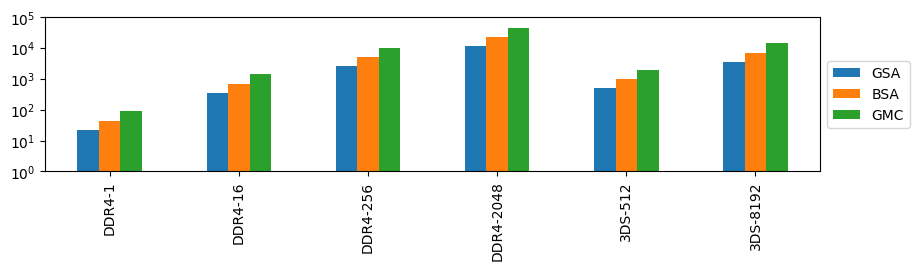

In [38]:
_yticks=10 ** np.arange(0, 6, dtype=float)
fig13 = df_plot_fig13.plot(kind="bar", logy=True, figsize=(10,2), yticks=_yticks)
fig13.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()